*updated 29 Jul 2025, Julian Mak (whatever with copyright, do what you want with this)

### As part of material for OCES 4303 "AI and Machine Learning in Marine Science" delivered at HKUST

For the latest version of the material, go to the public facing [GitHub](https://github.com/julianmak/OCES4303_ML_ocean) page.

---
# 3. Linear models and dimension reduction

Going to start with (multi-)linear models, which includes linear regression as a special case. As a recap, given multiple features $X = (X^{(1)}, X^{(2)}, \ldots)$ (denoted with superscripts, this is different to data sample which I denote by subscripts) and a **single** target $Y$, a linear model is of the form
\begin{equation*}
    \hat{Y} = a_0 + a_1 X^{(1)} + a_2 X_{(2)} + \ldots a_N X^{(N)}
\end{equation*}
where the ***model parameters*** or ***loading values*** are $\{a_0, a_1, \ldots, a_N\}$. The name of the game is find the set of $\{a_j\}$ values to minimise a some ***objective/cost/loss function*** $J$ to be specified: the different linear models basically differ in the choice of $J$, which leads to slightly different properties.

Given multiple features $X = (X^{(1)}, X^{(2)}, \ldots)$, you could also ask the question whether you really need all of it, or is a subset or some combination of them enough to provide model skill. This would be ***dimension reduction***, of which PCA is one methodology, and is closely related to ***feature identification***.

> ## Key Objective(s)
> 1. Explore the properties of a subset of linear models.
> 2. Further demonstrate the inbuilt `sklearn` cross-validation routines.
> 3. Explore some dimension reduction techniques.

Going to load a whole load of basic things.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

---
## a) Linear models

Suppose we take a loss function of the form
\begin{equation*}
    J = \frac{1}{2M}\|\hat{Y} - Y\|_{L^2}^2 + \alpha\rho\|a\|_{L^1} + \frac{\alpha(1-\rho)}{2}\|a\|_{L^2}^2,
\end{equation*}
made up of the mismatch and two penalisations of the value of the loading values (or control variables). The four variants we are considering here are:

* Standard ***linear regression***, which takes $\alpha = 0$, i.e. there no penalisation (the value of $M$ is actually irrelevant, but you could take it to be $M=1/2$).
* ***Ridge optimisation***, which takes $\rho=0$ (and $M=1/2$). Then $\alpha$ becomes a model hyperparameter controlling the strength of penalisation, where the values of the coefficients are not allowed to be too big.
* ***Lasso***, which takes $\rho=1$ (and $M$ is the number of samples). This choice of penalisation promotes **sparsity** in the loading values, i.e. we don't just want their size controlled, we don't even want them if possible.
* ***Elastic net***, which is a combination of ridge and lasso, and does both at the same time.

All the associated methodologies are done somehow, mostly using gradient descent type methods (see the lectures). It's easier to see what they do by using them.

In [2]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

### Demonstration: Basic fitting

To compare how the aforementioned linear models function, I am going to use artificial data
\begin{equation*}
    Y = X^2 + \epsilon, \qquad \epsilon\sim\mathcal{N}(0, \sigma)
\end{equation*}
where $\epsilon$ is some random noise determined by magnitude of $\sigma$. Here I don't scale the noise level with $X$, so as $X$ becomes big the effect of noise becomes smaller; however I am not going to take $X$ to be that big. The below shows the data (I am fixing the seed to make sure it is reproducible).

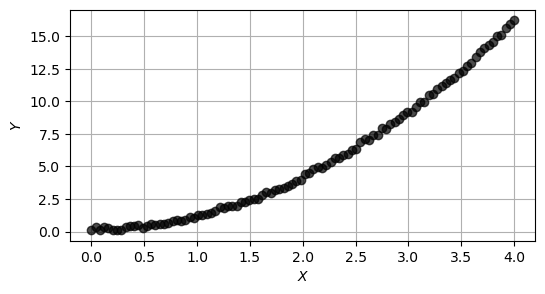

In [3]:
# generate the artificial data

sigma = 0.4
n = 100
X_vec = np.linspace(0, 4, n)  # including 0 here is potentially problematic, do it anyway...
np.random.seed(69)
Y = X_vec**2 + sigma * np.random.rand(n)

fig = plt.figure(figsize=(6, 3))
ax = plt.axes()
ax.plot(X_vec, Y, 'ko', alpha=0.7)
ax.set_xlabel(r"$X$")
ax.set_ylabel(r"$Y$")
ax.grid()

In this case I am not going to standarise the data nor do a train/test split (because this is really for demonstrating the differences in the behaviours in the linear model).

In this case we know what the data is so it should be clear that we want a model to return $f = X^2$ to us. However I am going to be perverse and assume I don't actually know that, and instead give it a ton of features and ask the model to find me a best fit of those. The features I am going to choose are $(1, X, X^2, X^3 \ldots X^{10})$: we would like to see whether we get $a_2 \approx 1$, and $a_{j\neq 2} \approx 0$.

To use the linear model formalism I am going to manually create the features via generating an $X$ that looks like
\begin{equation*}
    \begin{pmatrix}
        x_0^0 & x_0^1 & x_0^2 & \cdots & x_0^{10} \\
        x_1^0 & x_1^1 & x_1^2 & \cdots & x_1^{10} \\
        \vdots & \vdots & & & \vdots\\
        x_{99}^0 & x_{99}^1 & x_{99}^2 & \cdots & x_{99}^{10}
    \end{pmatrix},
\end{equation*}
where $x_i^j$ denotes data at position $i$ raised to the power $j$ ($i$-th sample and $j$-th feature). If you remember from your linear algebra, we are trying to get
\begin{equation*}
    \begin{pmatrix}
        x_0^0 & x_0^1 & x_0^2 & \cdots & x_0^{10} \\
        x_1^0 & x_1^1 & x_1^2 & \cdots & x_1^{10} \\
        \vdots & \vdots & & & \vdots\\
        x_{99}^0 & x_{99}^1 & x_{99}^2 & \cdots & x_{99}^{10}
    \end{pmatrix}
    \begin{pmatrix}
        a_0 \\ a_1 \\ \vdots \\ a_{10}
    \end{pmatrix}
    =
    \begin{pmatrix}
        y_0 \\ y_1 \\ \vdots \\ y_{99}
    \end{pmatrix}.
\end{equation*}
Notice the problem here the matrices are not square, and we are in the over-determined regime. The shape above is also good for `sklearn` because we want the array in `(n_samples, n_features)`: here we have 100 rows (100 samples), and 11 columns (11 features as degree 10 polynomial + a constant).

Just going to use the default options from the linear models.

/home/jclmak/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.302e+01, tolerance: 2.326e-01
  model = cd_fast.enet_coordinate_descent(
/home/jclmak/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.447e+01, tolerance: 2.326e-01
  model = cd_fast.enet_coordinate_descent(


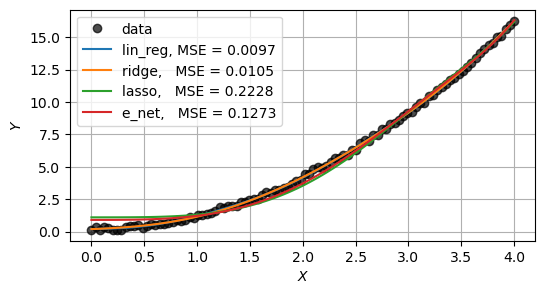

In [4]:
# create input features and do a load of fittings
deg = 10
X = np.zeros((n, deg+1))
for j in range(deg+1):
    X[:, j] = X_vec**j

lin_reg = LinearRegression().fit(X, Y)
ridge = Ridge().fit(X, Y)
lasso = Lasso().fit(X, Y)
e_net = ElasticNet().fit(X, Y)  # I can't get it to converge but it will return an answer

fig = plt.figure(figsize=(6, 3))
ax = plt.axes()
ax.plot(X_vec, Y, 'ko', alpha=0.7, label="data")
ax.plot(X_vec, lin_reg.predict(X),
        label=f"lin_reg, MSE = {mean_squared_error(Y, lin_reg.predict(X)):.4f}")
ax.plot(X_vec, ridge.predict(X),
        label=f"ridge,   MSE = {mean_squared_error(Y, ridge.predict(X)):.4f}")
ax.plot(X_vec, lasso.predict(X),
        label=f"lasso,   MSE = {mean_squared_error(Y, lasso.predict(X)):.4f}")
ax.plot(X_vec, e_net.predict(X),
        label=f"e_net,   MSE = {mean_squared_error(Y, e_net.predict(X)):.4f}")
ax.set_xlabel(r"$X$")
ax.set_ylabel(r"$Y$")
ax.grid()
ax.legend();

On mine it says `ElasticNet` did not converge, although as you can see the skill is actually ok.

It is of interest also to have a look at the coefficients obtained.

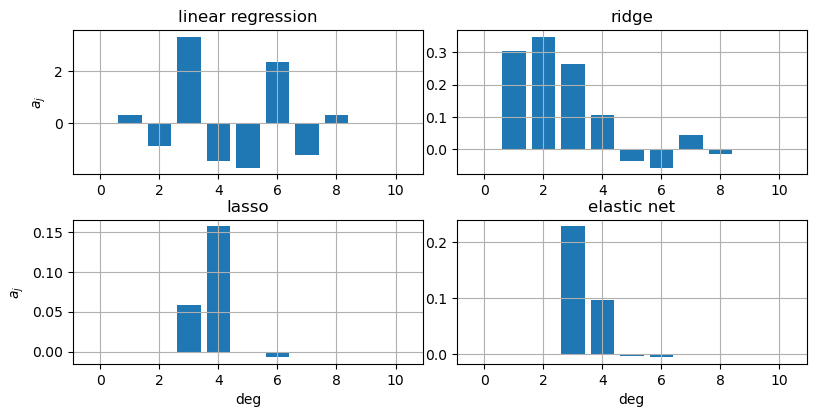

In [5]:
# plot out the coefficients of the models or the loading values?
fig = plt.figure(figsize=(8, 4))

ax = plt.subplot(2, 2, 1)
ax.bar(np.arange(deg+1), lin_reg.coef_)
ax.set_title("linear regression")
ax.set_ylabel(r"$a_j$")
ax.grid()

ax = plt.subplot(2, 2, 2)
ax.bar(np.arange(deg+1), ridge.coef_)
ax.set_title("ridge")
ax.grid()

ax = plt.subplot(2, 2, 3)
ax.bar(np.arange(deg+1), lasso.coef_)
ax.set_title("lasso")
ax.set_xlabel(r"deg")
ax.set_ylabel(r"$a_j$")
ax.grid()

ax = plt.subplot(2, 2, 4)
ax.bar(np.arange(deg+1), e_net.coef_)
ax.set_title("elastic net")
ax.set_xlabel(r"deg")
ax.grid()

plt.tight_layout(pad=0.1);

Several things to notice here:

* Linear regression and ridge both use $L^2$ in the loss, and the result model coefficients are noticeably non-zero across the board (smaller in ridge though). This is not seen in Lasso and elastic net, which include a $L^1$ term in the loss.
* Ridge is really the only one that predicts the loading in the degree 2 term ($a_2$), although there is loading everywhere else.
* Interestingly Lasso predicts a dominant loading at degree 4. This is actually plausible, because for small enough $X$ values (default here being from $0$ to $4$) $X^2$ and $X^4$ can be argued to not be that dissimilar in shape (and could argued to be the case for the other even powers).

Below shows how they perform poorly in extrapolation, demonstrating a signficant issue with over-fitting.

In [6]:
# do a single extrapolation
x0 = 7.0
X_extra = np.zeros((1, deg+1))
for j in range(deg+1):
    X_extra[:, j] = x0**j
    
# compute some errors
print(f"target value at x0         = {x0**2:.4f}")
print(f"lin_reg extrapolated value = {lin_reg.predict(X_extra)[0]:.6f}")
print(f"ridge   extrapolated value = {ridge.predict(X_extra)[0]:.6f}")
print(f"lasso   extrapolated value = {lasso.predict(X_extra)[0]:.6f}")
print(f"e_net   extrapolated value = {e_net.predict(X_extra)[0]:.6f}")
print(" ")

target value at x0         = 49.0000
lin_reg extrapolated value = 15820.321173
ridge   extrapolated value = -2194.590262
lasso   extrapolated value = 2212.994511
e_net   extrapolated value = 1952.971960
 


> <span style="color:red">Q.</span> See how the above behaviours change if you expand decreasing the training range (e.g. instead of `X_vec = (0, 4)` try `(0, 8)`, or `(4, 8)`, or randomly pick some values to do the model fitting in some specified region etc.)
>
> <span style="color:red">Q.</span> Introduce some variability and do an ensemble of fittings (easiest is via `train_test_split`, although you can do the random picking within a region specified above also). Quantify the robustness of the above properties (e.g. do box-plots/histograms over the ensemble of the loading values, errors etc.)

### Cross-validation again, but done in a more sleek way

Now that we have models of sufficient complexity and within the `sklearn` family we could use some in-built tools there to help with cross-validation (although it is good practice to do it once or twice by hand before). Below for example demonstrates $k$-fold cross-validation that differs in the train/test splitting using `ridge` (others have some issues with convergence sometimes).

In [7]:
from sklearn.model_selection import cross_val_score

model = Ridge(alpha=1) # initialise but don't fit
scores = cross_val_score(model, X, Y, cv=5)  # uses default score of estimator (R^2 here)

print(f"score = {scores}")
print(f"scores mean accuracy {scores.mean():.2f}")
print(f"score std {scores.std():.2f}")
print(" ")

score = [ -1.69222657   0.89497827   0.98435762   0.99212207 -74.72480873]
scores mean accuracy -14.71
score std 30.03
 


Without specifying the score of interest it will use the default, which for regression is the $R^2$ score. When I do it there are cases where models are clearly breaking with very large scores...

Can randomise it a bit more and be more specific in the choice of scores (see [here](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) for a list) as follows.

> NOTE: You can pass a list of scores in, e.g. `scoring=["neg_mean_squared_error", "neg_mean_absolute_error"]`, but the below print commands will need to be modified.

In [8]:
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=5, test_size=0.2)               # specify split
scores = cross_val_score(model, X, Y, cv=cv,
                        scoring="neg_mean_squared_error")  # specify score

print(f"score = {scores}")
print(f"scores mean accuracy {scores.mean():.2f}")
print(f"score std {scores.std():.2f}")
print(" ")

score = [-0.0148694  -0.0085571  -0.01253073 -0.01810663 -0.00767032]
scores mean accuracy -0.01
score std 0.00
 


These can then be piggybacked for doing model selection and hyperparameter tuning, manually or using other `sklearn` objects. For length reasons I'm going to leave this as an extended exercise instead.

---
## b) Dimension reduction (cf. data feature identification)

An observation with the above linear model example is that you could in principle get reasonably good model skill without having to have a lot of features (e.g. the $L^1$ penalised models). That's a good thing presumably because that helps in principle in avoiding over-fitting, and it also speeds up the training stage in principle (because you are throwing less data in). Ways to identify the most useful "features" for model training/skill is thus of interest: this would be ***dimension reduction*** in that out of the possible space of results allowed by all data, you want to find a useful ***feature space*** that is presumably lower dimenion and less complex than the original space.

Asking for the *most* skillful one is probably quite a difficult question to answer. We will instead look for ways to simply find feature spaces that are simpler.

### Principal Component Analysis (PCA)

(Or sometimes Empirical Orthogonal Functions (EOF)s particularly when space dimensions are involved.) This we already encountered in OCES 3301 and is essentially finding linear combinations of the features that maximises the variance explained in the data (again, these are optimisation problems, just with a different choice of loss function).

For example, for the `penguins` data, instead of the feature space being `(bill_length, bill_depth, flipper_length, body_mass)`, it could be that (say) `(bill_length + 2 body_mass, flipper_length + body_mass - bill_depth)` actually explains the data the best. This may not make sense scientifically, but that's not the point: PCA only seeks to maximise variance explained, variance is related to correlations, and correlation does not imply causation.

> <span style="color:red">Q.</span> Have a think why there is no real reason to do a PCA as such for the polynomial fitting problem above.

Although some of this was already done in OCES 3301, the below is included mostly for completeness.

> NOTE: If you know this stuff, then PCA is just a SVD ranked by the magnitude of the singular values. The singular vectors are the features of interest and are orthogonal by construction (hence the O in EOF). When the matrix is squre then this would be a diagnoalisation of covariance matrix in terms of its eigenvectors.

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# load the penguin data
option = "remote"

if option == "local":
    print("loading data locally (assumes file has already been downloaded)")
    path = "penguins.csv"
elif option == "remote":
    print("loading data remotely")
    path = "https://raw.githubusercontent.com/julianmak/OCES4303_ML_ocean/refs/heads/main/penguins.csv"
else:
    raise ValueError("INVALID OPTION: use 'remote' or 'local'")

df = pd.read_csv(path)

loading data remotely


First going to do simple (and arguably unnecessary) case of two variables to two other variables, in which case we are simply dealing with a co-ordinate transformation.

> NOTE: The thing with PCA is that it does depend quite strongly on choice of pre-processing. By default you should do data scaling before you do PCA.

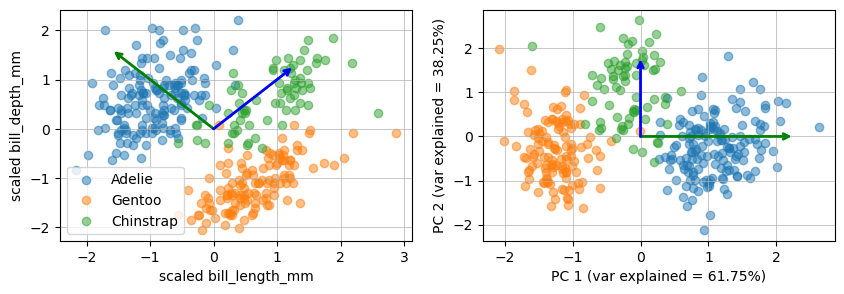

In [10]:
# PCA of two variables to two other variables (i.e. a co-ordinate transformation)
features = ['bill_length_mm', 'bill_depth_mm']
X = df[features].values

# scale and fit the data
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
pca.fit(X_scaled)

fig = plt.figure(figsize=(10, 3))

# input in scaled space
ax = plt.subplot(1, 2, 1)
for species in df["species"].unique():   # pick out all unique entries under `species`
    ax.scatter(X_scaled[df["species"] == species, 0],
               X_scaled[df["species"] == species, 1],
               label=species,
               alpha=0.5,  # fade this for demonstration later
               )
ax.annotate("", 
            pca.mean_ + pca.components_[0] * 2 * np.sqrt(pca.explained_variance_[0]), 
            pca.mean_,
            arrowprops=dict(color="green", arrowstyle='->', linewidth=2, shrinkA=0, shrinkB=0))
ax.annotate("", 
            pca.mean_ + pca.components_[1] * 2 * np.sqrt(pca.explained_variance_[1]), 
            pca.mean_,
            arrowprops=dict(color="blue", arrowstyle='->', linewidth=2, shrinkA=0, shrinkB=0))
ax.set_xlabel(f"scaled {features[0]}")
ax.set_ylabel(f"scaled {features[1]}")
ax.grid(lw=0.5, zorder=0)
ax.legend()

# inputs in PCA basis
X_pca = pca.transform(X_scaled)

ax = plt.subplot(1, 2, 2)

for species in df["species"].unique():   # pick out all unique entries under `species`
    ax.scatter(X_pca[df["species"] == species, 0],
               X_pca[df["species"] == species, 1],
               label=species,
               alpha=0.5,  # fade this for demonstration later
               )
ax.annotate("", 
            [2 * np.sqrt(pca.explained_variance_[0]), 0], 
            [0, 0],
            arrowprops=dict(color="green", arrowstyle='->', linewidth=2, shrinkA=0, shrinkB=0))
ax.annotate("", 
            [0, 2 * np.sqrt(pca.explained_variance_[1])], 
            [0, 0],
            arrowprops=dict(color="blue", arrowstyle='->', linewidth=2, shrinkA=0, shrinkB=0))
ax.set_xlabel(f"PC 1 (var explained = {pca.explained_variance_ratio_[0]*100:.2f}%)")
ax.set_ylabel(f"PC 2 (var explained = {pca.explained_variance_ratio_[1]*100:.2f}%)")
ax.grid(lw=0.5, zorder=0);

Above looks like a rotation, a flip about the axis defined defined by the blue arrow, and then some mild scaling to me. 

A more interesting case is if I dump everything in, which would be a reduction of four dimensions to two dimensions.

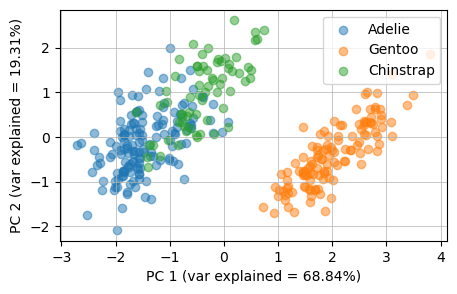

In [11]:
# throw everything into the PCA (in this case ignore species)
features = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]
X = df[features].values

# scale data, fit PCA (do 2 componens here), transform data
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

fig = plt.figure(figsize=(5, 3))
ax = plt.axes()
for species in df["species"].unique():   # pick out all unique entries under `species`
    ax.scatter(X_pca[df["species"] == species, 0],
               X_pca[df["species"] == species, 1],
               label=species,
               alpha=0.5,  # fade this for demonstration later
               )
ax.set_xlabel(f"PC 1 (var explained = {pca.explained_variance_ratio_[0]*100:.2f}%)")
ax.set_ylabel(f"PC 2 (var explained = {pca.explained_variance_ratio_[1]*100:.2f}%)")
ax.grid(lw=0.5, zorder=0)
ax.legend();

Note the percentages in this case do not sum to 100%, because we have discarded two dimensions. We can query the percentages and also the feature combinations as follows.

In [12]:
# print to screen the percentages and PC constituents

for i in range(len(pca.explained_variance_ratio_)):
    print(f"PC {i+1} explains {pca.explained_variance_ratio_[i]*100:.2f}% of variance")
print(" ")
for i in range(len(pca.explained_variance_ratio_)):
    print(f"""PC {i+1} = {pca.components_[i, 0]:.4f} * {features[0]} +
       {pca.components_[i, 1]:.4f} * {features[1]} +
       {pca.components_[i, 2]:.4f} * {features[2]} +
       {pca.components_[i, 3]:.4f} * {features[3]}""")
print(" ")

PC 1 explains 68.84% of variance
PC 2 explains 19.31% of variance
 
PC 1 = 0.4553 * bill_length_mm +
       -0.4003 * bill_depth_mm +
       0.5760 * flipper_length_mm +
       0.5484 * body_mass_g
PC 2 = 0.5970 * bill_length_mm +
       0.7978 * bill_depth_mm +
       0.0023 * flipper_length_mm +
       0.0844 * body_mass_g
 


### Locally linear embedding and $t$-SNE

The next two we are only going to skim briefly, but they will come back next lecture when we talk about ***clustering***.

The original paper to ***Locally Linear Embedding*** is [here](https://www.science.org/doi/10.1126/science.290.5500.2323). This you can think of as PCAs done locally, and these local regions are patched together to form a best fit global reduction. Below just demonstrates how these are used and the result on the penguin data, although it may make more sense after next lecture with a better example where it will significantly affect the results from clustering.

> NOTE: This I think is a bit like in differential geometry where you find a whole load of local co-ordinate charts, and then patch it up to find a good global atlas.

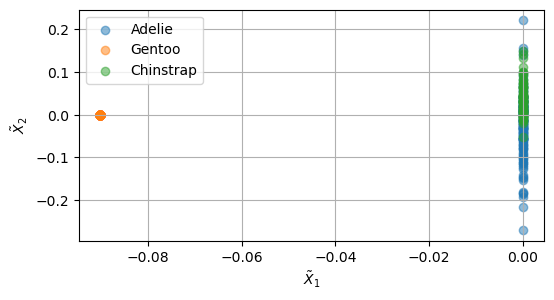

In [13]:
from sklearn.manifold import LocallyLinearEmbedding

features = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]
X = df[features].values

lle = LocallyLinearEmbedding()  # default of 2 components (so 2 dimensions)
X = StandardScaler().fit_transform(X)  # comment to switch of scaling if wanted
X_lle = lle.fit_transform(X)

fig = plt.figure(figsize=(6, 3))
ax = plt.axes()
for species in df["species"].unique():   # pick out all unique entries under `species`
    ax.scatter(X_lle[df["species"] == species, 0],
               X_lle[df["species"] == species, 1],
               label=species,
               alpha=0.5,  # fade this for demonstration later
               )
ax.set_xlabel(r"$\tilde{X}_1$")
ax.set_ylabel(r"$\tilde{X}_2$")
ax.grid()
ax.legend();

This seems to suggest there is a projection that can strongly separate out the Gentoo penguins from others, which may help in classification tasks for example.

> <span style="color:red">Q.</span> The default option above is `standard`, but there are other options that can be specified (e.g. `ltsa`, `hessian`, `modified`). See [here](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.LocallyLinearEmbedding.html#sklearn.manifold.LocallyLinearEmbedding) for what those mean and try a few of those out. Might also be good to revisit this in the next lecture.

***$t$-distributed Stochastic Neighbor Embedding*** ($t$-SNE) tries to do something similar but instead assigns how close data is in the original space by Gaussian probabilities, and the closeness in the transformed space by Student $t$-distributions (cf. `05_hypothesis_testing` in OCES 3301), and together aids in looking for a projection that is sensitive to local data structures. While the former method is better for continuously distributed samples, the method here might be better for local samples.

> NOTE: $t$-SNE can be slow.
>
> The default has `TSNE(init="pca")`, which helps with stability. `init="random"` is the other option.

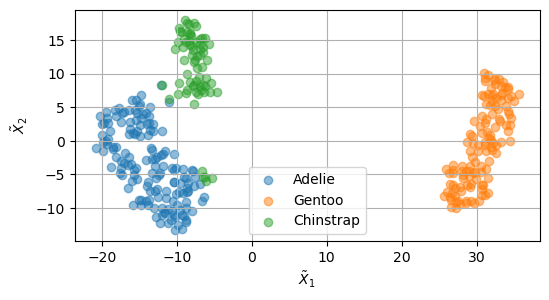

In [14]:
from sklearn.manifold import TSNE

features = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]
X = df[features].values

tsne = TSNE()  # default of 2 components (so 2 dimensions)
X = StandardScaler().fit_transform(X)  # comment to switch of scaling if wanted
X_tsne = tsne.fit_transform(X)

fig = plt.figure(figsize=(6, 3))
ax = plt.axes()
for species in df["species"].unique():   # pick out all unique entries under `species`
    ax.scatter(X_tsne[df["species"] == species, 0],
               X_tsne[df["species"] == species, 1],
               label=species,
               alpha=0.5,  # fade this for demonstration later
               )
ax.set_xlabel(r"$\tilde{X}_1$")
ax.set_ylabel(r"$\tilde{X}_2$")
ax.grid()
ax.legend();

So note here that we get fairly well separated clusters of points (with a little bit of mixing between Adelie and Chinstrap), which will presumably aid in clustering and/or classification tasks.

> <span style="color:red">Q.</span> Switch off data standardisation and see what happens. Is this expected?
> 
> <span style="color:red">Q.</span> Change over to `init="random"` and see how the clustering changes. You may want to run multiple instances to check for robustness and/or wellness of separation.

---
## c) Demonstration: Eigencat

A fun application of PCA would be the [eigenpets](https://bioramble.wordpress.com/2015/09/01/pca-part-5-eigenpets/) example (cf. [eigenfaces](https://en.wikipedia.org/wiki/Eigenface)). Given a collection of cat images, what is the "pattern" that explains most of the variance? This has uses in things like image/facial recognition: you might imagine certain species of cats have a particular signature in some modes. More generally, this might be useful in ***classification*** tasks where you are trying to identify species and the like. Having these features may also be helpful for reconstruction of broken images.

The idea is quite simple: instead of a set of images being `(n_samples, width, height)`, we simply reshape/flatten it into `(n_samples, pixels)`; this is what was done for computing EOFs in OCES 3301. Then you dump it into the PCA routine as usual. We first have a load and plot out some of the dataset.

loading data remotely
data array shape is (80, 4096)
 


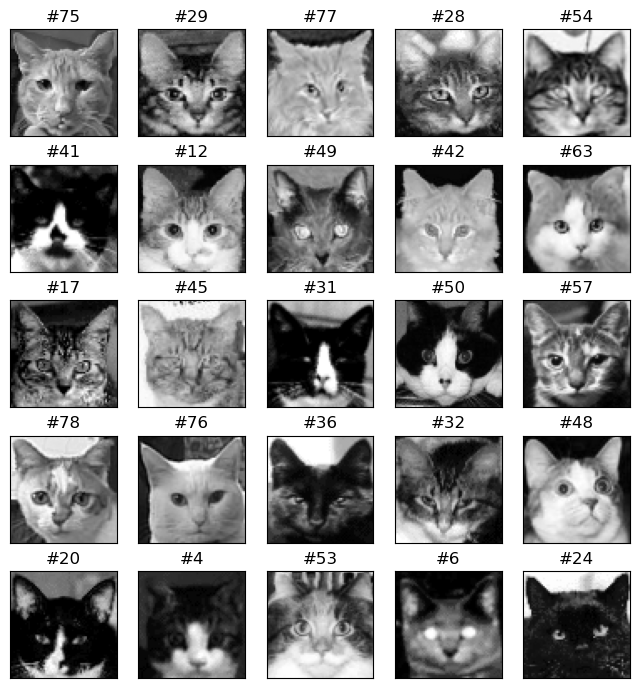

In [15]:
# don't read the headers

option = "remote"

if option == "local":
    print("loading data locally (assumes file has already been downloaded)")
    path = "cat.csv"
elif option == "remote":
    print("loading data remotely")
    path = "https://raw.githubusercontent.com/julianmak/OCES4303_ML_ocean/refs/heads/main/cat.csv"
else:
    raise ValueError("INVALID OPTION: use 'remote' or 'local'")

df = pd.read_csv(path, header=None).T # make "features" the axis=-1
X = df.values
print(f"data array shape is {X.shape}")
print(" ")

# generate a list of 25 indices (generate full list, shuffle, select first 25, so no repeats)
ind = np.arange(80)
np.random.shuffle(ind)  # syntax for shuffle: not used like a function with input output...

# sample show (on-the-fly reshape data)
fig = plt.figure(figsize=(8, 8.5))
for i in range(25):
    ax = plt.subplot(5, 5, i+1)
    ax.imshow(np.reshape(X[ind[i], :], (64, 64)).T, cmap="gray")
    ax.set_title(f"#{ind[i]}")
    ax.set_xticks([]); ax.set_yticks([]);

So here the raw data has already been flattened and is in the right shape (otherwise just transpose it with `.T`). We will PCA it accordingly, but I won't standardise it in this case (though probably should to remove the mean).

> <span style="color:red">Q.</span> Have a think why I made that choice, and possibly investigate later what consequences you may have if you do standardise in the usual way (uncomment two of the lines below), or with other choices of standardisation.

In [16]:
# scale data, fit and transform PCA (do 40 componens for the hell of it)
# scale = StandardScaler()
# X = scale.fit_transform(X) # if standardising in cell above then images are less sharp (Q: why?)
pca = PCA(n_components=40)
X_pca = pca.fit_transform(X)

# should be (n_EOF, pixels)
print(f"PCA components with shape {pca.components_.shape}")
print(" ")

PCA components with shape (40, 4096)
 


The transformed data should be in `(n_EOF, pixels)` in this case. We can reshape and plot them out accordingly.

Note that I am calling the patterns the EOFs, while the loading I am going call the PCs (really I would call them the singular vectors and the coefficients). In this case the mathematical expresion might be less ambiguous:
\begin{equation*}
    \mathrm{Image}(\mathrm{pixels}) = \sum_i \mbox{PC}_i \times \mbox{EOF}_i(\mathrm{pixels}),
\end{equation*}
and each image differs in the $\mbox{PC}_i$.

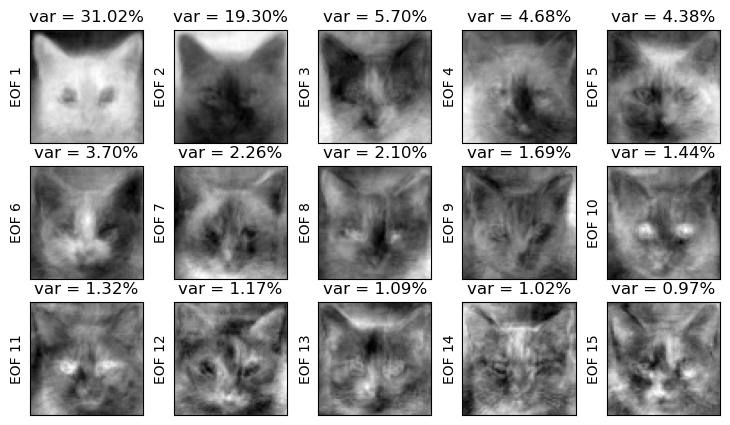

In [17]:
# eigencats
fig = plt.figure(figsize=(9, 5))
for i in range(15):
    ax = plt.subplot(3, 5, i+1)
    ax.imshow(np.reshape(pca.components_[i, :], (64, 64)).T, cmap="gray")
    ax.set_title(f"var = {pca.explained_variance_ratio_[i] * 100:.2f}%")
    ax.set_ylabel(f"EOF {i+1}")
    ax.set_xticks([]); ax.set_yticks([]);

Some observations:

* Here you might think EOF1 probably measures colour: if the associated PC1 is positive then we are dealing with lighter coloured cats probably, and vice-versa for negative PC1s.
* EOF2 and 3 might be about facial patterns.
* EOF4 and 5 might be about "chubby-ness" of face?
* Extra details on the later patterns.

These are all speculations of course, because again PCA is statistical and only finds the correlations, whereas it is me who attributes the causality.

Below are some selected examples of cats with increasing numbers of EOFs added, i.e. I am doing
\begin{equation*}
    \mathrm{Reconstructed\ Image}(\mathrm{pixels}) \approx \sum_i^m \mbox{PC}_i \times \mbox{EOF}_i(\mathrm{pixels})
\end{equation*}
with increasing $m$. I am also going to plot out the corresponding loading values $\mbox{PC}_i$ as a graph for the selected samples.

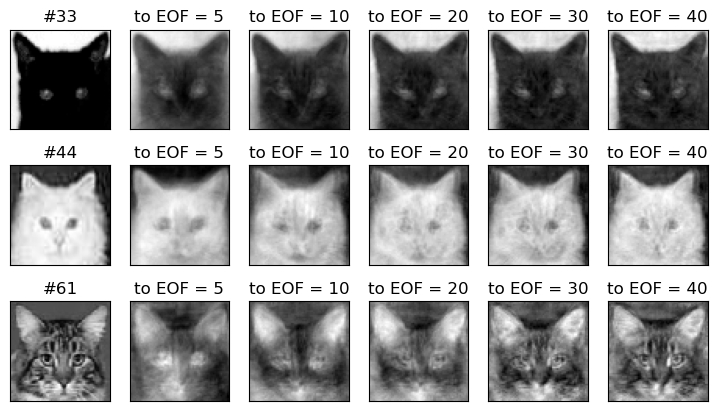

In [18]:
# sample decomposition (X_pca above is the PC)

cat_num = [33, 44, 61]
pca_ind = [5, 10, 20, 30, 40]

# do some plots to show decomposition
fig = plt.figure(figsize=(9, 5))

count = 0

for j in range(3):
    cat_ind = cat_num[j]
    for i in range(6):
        ax = plt.subplot(3, 6, (j*6)+i+1)
        # plot original image
        if i % 6 == 0:
            ax.imshow(np.reshape(X[cat_ind, :], (64, 64)).T, cmap="gray")
            ax.set_title(f"#{cat_num[j]}")
        # plot the reconstruction with increasing number of PCs
        else:
            # sum to get (scaled) reconstruction via sum_i (PC_i * EOF_i)
            ind = pca_ind[i-1]
            dum = np.sum(X_pca[cat_ind, :ind] * pca.components_[:ind, :].T, axis=-1)
            ax.imshow(np.reshape(dum, (64, 64)).T, cmap="gray")
            ax.set_title(f"to EOF = {pca_ind[i-1]}")
            count += 1
    
        ax.set_xticks([]); ax.set_yticks([]);

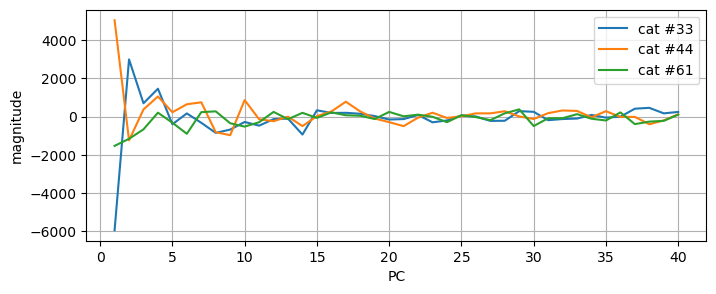

In [19]:
# plot out the PC decomposition
fig = plt.figure(figsize=(8, 3))
ax = plt.axes()
for i in range(len(cat_num)):
    ax.plot(np.arange(1, X_pca.shape[-1]+1), X_pca[cat_num[i], :], label=f"cat #{cat_num[i]}")
ax.set_xlabel("PC"); ax.set_ylabel("magnitude")
ax.grid()
ax.legend();

Perhaps as expected we see that the black and white cat differs primarily in PC1. The tabby cat has a different signature on the other hand. This may aid in the classification of images via a machine learning algorithm in the following ways:

* The different signatures might be distinguishing feature that allows separation of labels (see Lec 05 when we talk about classification tasks).
* Instead of throwing the above images (which is $64^2 = 4096$ features, i.e. high dimension space), we are instead doing learning in a much lower dimension space (in this case 40), which may be good in mitigation of over-fitting.

> <span style="color:red">Q.</span> I am plotting the eigenpets Here I am plotting the SCALED images. You can consider unscale them by `scale.inverse_transform(pca.components_)` say, but then something a bit weird happens. See what that is, and see if you have an explanation for this.

### A fun demonstration and also a warning

I am going to go nuts and load an even larger dataset and do the same thing. Here I am going to do a PCA with 2000 components (again not standardising). This takes a bit of time (no more than 10 seconds on my laptop).

In [20]:
# 2000 images here; data ordering with the same convention
option = "remote"

if option == "local":
    print("loading data locally (assumes file has already been downloaded)")
    path = "cat_bw_enlarged.csv"
elif option == "remote":
    print("loading data remotely")
    path = "https://raw.githubusercontent.com/julianmak/OCES4303_ML_ocean/refs/heads/main/cat_bw_enlarged.csv"
else:
    raise ValueError("INVALID OPTION: use 'remote' or 'local'")

df = pd.read_csv(path, header=None).T # make "features" the axis=-1
X = df.values

# scale data, fit PCA, transform data
pca = PCA(n_components=2000)
X_pca = pca.fit_transform(X)

loading data remotely


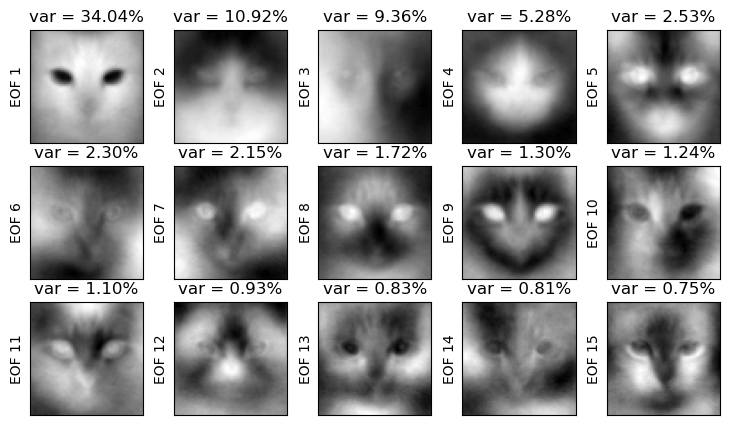

In [21]:
# expanded eigencats
fig = plt.figure(figsize=(9, 5))
for i in range(15):
    ax = plt.subplot(3, 5, i+1)
    ax.imshow(np.reshape(pca.components_[i, :], (64, 64)).T, cmap="gray")
    ax.set_title(f"var = {pca.explained_variance_ratio_[i] * 100:.2f}%")
    ax.set_ylabel(f"EOF {i+1}")
    ax.set_xticks([]); ax.set_yticks([]);

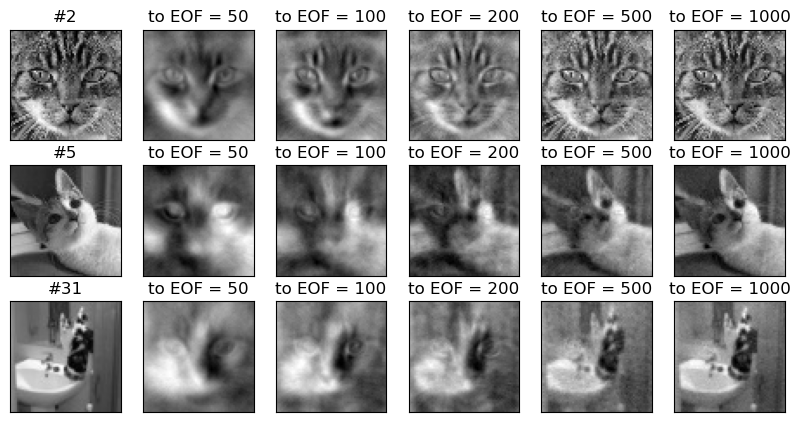

In [22]:
# sample decomposition (X_pca above is the PC)

cat_num = [2, 5, 31]
pca_ind = [50, 100, 200, 500, 1000]

# do some plots to show decomposition
fig = plt.figure(figsize=(10, 5))

count = 0

for j in range(3):
    cat_ind = cat_num[j]
    for i in range(6):
        ax = plt.subplot(3, 6, (j*6)+i+1)
        # plot original image
        if i % 6 == 0:
            ax.imshow(np.reshape(X[cat_ind, :], (64, 64)).T, cmap="gray")
            ax.set_title(f"#{cat_num[j]}")
        # plot the reconstruction with increasing number of PCs
        else:
            # sum to get (scaled) reconstruction via sum_i (PC_i * EOF_i)
            ind = pca_ind[i-1]
            dum = np.sum(X_pca[cat_ind, :ind] * pca.components_[:ind, :].T, axis=-1)
            ax.imshow(np.reshape(dum, (64, 64)).T, cmap="gray")
            ax.set_title(f"to EOF = {pca_ind[i-1]}")
            count += 1
    
        ax.set_xticks([]); ax.set_yticks([]);

So notice that this larger dataset is not as clean in that we have cat images that are

* Missing features (the first one isn't showing the ears)
* Not centred (includes whole fact but rotated somewhat)
* Not focused (showing whole body as well as other presumably irrelevant features)

By enlarging the dataset with extra details I am massively increasing the dimension and extent of my feature space, which may or may not be a good thing. With this I can fit whatever I like to the trained set, as demonstrated below.

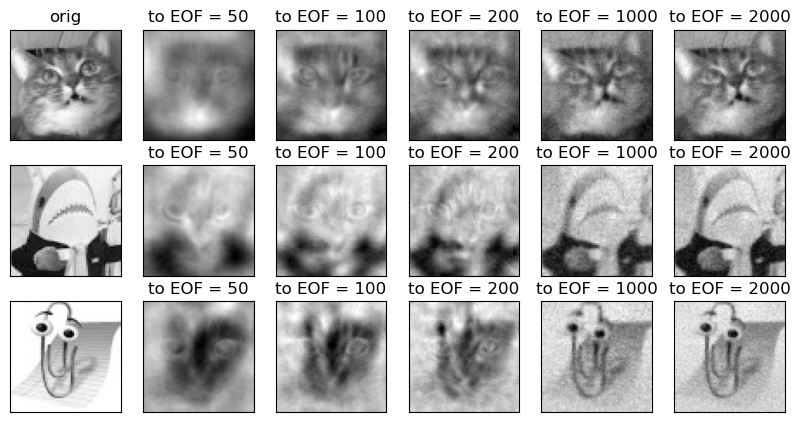

In [23]:
# fit some doofuses

targets = ["miffy_gormless", "blauhaj", "clippy"]
pca_ind = [50, 100, 200, 1000, 2000]

# do some plots to show decomposition
fig = plt.figure(figsize=(10, 5))

count = 0

for j in range(3):
    X = plt.imread(f"data/{targets[j]}.jpg").T.flatten()
    X_pca = pca.transform(X.reshape(1, -1))
    for i in range(6):
        ax = plt.subplot(3, 6, (j*6)+i+1)
        # plot original image
        if i % 6 == 0:
            ax.imshow(np.reshape(X, (64, 64)).T, cmap="gray")
            if j == 0: 
                ax.set_title("orig")
        # plot the reconstruction with increasing number of PCs
        else:
            # sum to get (scaled) reconstruction via sum_i (PC_i * EOF_i)
            ind = pca_ind[i-1]
            dum = np.sum(X_pca[0, :ind] * pca.components_[:ind, :].T, axis=-1)
            ax.imshow(np.reshape(dum, (64, 64)).T, cmap="gray")
            ax.set_title(f"to EOF = {pca_ind[i-1]}")
            count += 1
    
        ax.set_xticks([]); ax.set_yticks([]);

With the expanded set I can fit:

* A cat that wasn't in the sample
* An animal that's not a cat
* Not even an animal

The first is good but the latter are not. You can imagine I train a classifier, then it might identify the bottom one as a "siamese cat".

A take home message here may be that more data is not always good: it does expand the sampled pdf, but it also allows for more possibility of hallucinations with the extra complexity. Just like "practice makes perfect" is really "PERFECT practice makes perfect", we should really have "more GOOD data is good".

> NOTE: There are of course data choices that can be used to mitigate these hallucinations (a simple one would be to add `not cat` labels). There are also model design choices that can be taken as well, but those will be beyond the scope of this course.

> <span style="color:red">Q.</span> Exercise in data processing: Find your favourite image and try and see if you can use the expanded eigenpets with it.
>
> <span style="color:red">Q.</span> Consider doing locally linear embedding or $t$-SNE instead of PCA. Probably don't do it on the extended cat set particularly with $t$-SNE, because that will probably kill your computer.

----------------
# More involved exercises with this notebook

## 1) Polynomial regression

Consider doing polynomial regression using `sklearn.preprocessing.PolynomialFeatures`; this might be easier with [`pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) also. I basically did it manually above.

(Essentially choosing a [basis for the features](https://scikit-learn.org/stable/modules/linear_model.html#polynomial-regression-extending-linear-models-with-basis-functions), and is related to what we would do with [SINDy](https://pysindy.readthedocs.io/en/latest/), which we may visit in the bonus material.)

## 2) Generalised Linear Models (GLMs)

Have a look at [GLMs](https://scikit-learn.org/stable/modules/linear_model.html#generalized-linear-models), and try applying this in some of the examples above (or make up / apply to your own synthetic/real examples). 

(The reason we don't touch this is because this requires you knowing more things about other probability distribution funtcions.)

## 3) Bayesian regression

Have a look at [Bayesian regession](https://scikit-learn.org/stable/modules/linear_model.html#bayesian-regression), and try applying this in some of the examples above (or make up / apply to your own synthetic/real examples).

(The reason we don't touch this is because this requires you knowing the Bayesian formalism of probability/statistics.)

## 4) Predicting cat faces, and on model interpretability

Going to the raw images of cats, consider training linear models of the above ilk on half the face and using it to predict the other half. Analyse the skill on training data, testing data, the need for standardising the data, analysis of the model coefficients, dependence on the propotion of face exposed to model, cross-validation and etc.

From a coding point of view it is potentially easier to use the left half of the face to predict the right half (idea below). You can try top and bottom also.

<img src="https://i.imgur.com/G7xJJvu.jpeg" width="500" alt='cursed prediction'>

One interest here is in the model coefficients: the loading values would provide a suggestion on which pixels may matter the most in the training of the model for the prediction problem, which aids in ***interpretability*** of the model. We will come back to do this when we get to `07_Neural_Networks`.

## 5) Classification tasks and eigenpets

We will come back to this in `05_classification`. There is the analogous dog data called `dog.csv`; try and do an eigenpets decomposition say.

Then have a think how you might do classification of an image based on the features generated from eigenpets, and try and do that if you want to. One way to do it is simply say $Y=1$ is cat and $Y=-1$ is dog or analogously (i.e. you label the data), then you train a linear model based on the image and/or the eigenpet features. The predicted values will not be exactly $1$ or $-1$, but then you only need the sign of it (e.g. if predicted value is positive then it is a cat, and vice-versa).

## 6) Argo data

#### (This one is related to the upcoming assignment.) 

Consider training models on the Argo profile to predict one of the depth, temperature and salinity from the other two (as a start). Do the usual data scaling, evaluation for robustness, cross-validation etc.

An extra thing to do would be to evalute whether the predictions are physically plausible: 

* It is entirely possible the prediction leads to a density that is in fact gravitationally unstable, when we don't think this is likely the case
* (Harder) The resulting density prediction leads to a contradicting the buoyancy frequency $N^2$ that is also present in the data

## 7) Hyperparameter tuning and model selection

#### (May help with all upcoming assignments.) 

Instead of doing things manually, have a look at [here](https://scikit-learn.org/stable/modules/grid_search.html#) to see how you might do hyperparameter tuning of the model. Within the same manual there are suggestions on how you might model selection also.

## 8) Spectral analysis

If you have seen Fourier analysis before, consider doing dimension reduction / data compression via Fourier transform (e.g. `np.rfft` or similar); this is a fairly standard thing to do for acoustic data and signal processing for example (e.g. music identification software such as [Shazam](https://www.shazam.com/)), and maintains the feature orthogonality property.

If you are feeling adventurous, you could try more general transforms (e.g. spherical harmonics, Bessel functions, wavelets).

(There is then potentially something to be said about doing machine learning to predict things leveraging the data structure these spectral/wavelet spaces, which can be more stable and robust. See for example [this paper](https://www.nature.com/articles/s41467-021-21481-0) and maybe a video on YouTube by [Steve Brunton](https://www.youtube.com/watch?v=W8PybqAk6Ik)

## 9) Time-series forecasting

Consider taking something like the `elnino34_sst.data` and train a linear model to do forecasting: given previous now and maybe some previous time data (these are your $X$s), predict the next time (these are your $Y$s). These are basically [ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average)-like models but with no noise terms.

How many previous times you put in is up to you, but note that if you use the whole time series your model will be complex and you have very few values to regress over. A shorter time series may allow you to do train/test split.

If you need to, I suppose you could "cheat" and generate multiple similar time series by taking the `elnino34_sst.data` and add noise to it, and call that a new time series; this is a bit like ***bootstrapping*** I would imagine.

(You could also do something a bit more controlled by generating your time-series with a model of your choice. A particularly simple one would be a predator-prey or [Lotka-Volterra model](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations); if you look into the OCES 3301 repository there should already be an implementation there. A harder one would be a [Lorenz system](https://en.wikipedia.org/wiki/Lorenz_system).)